In [1]:
#https://www.tensorflow.org/api_docs/python/tf
#https://keras.io/guides/
import tensorflow as tf
import numpy as np
from tensorflow.keras import Model, layers
from glob import glob
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT")

Num GPUs Available:  1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


In [3]:
original = glob('C:/Users/Daniel/Documents/MCI/bach/jupyter/data/bearbeitet/train/original/*.*')
smooth = glob('C:/Users/Daniel/Documents/MCI/bach/jupyter/data/bearbeitet/train/smooth/*.*')
pop = glob('C:/Users/Daniel/Documents/MCI/bach/jupyter/data/bearbeitet/train/pop/*.*')
accentuate = glob('C:/Users/Daniel/Documents/MCI/bach/jupyter/data/bearbeitet/train/accentuate/*.*')
morning = glob('C:/Users/Daniel/Documents/MCI/bach/jupyter/data/bearbeitet/train/morning/*.*')
DramaDark = glob('C:/Users/Daniel/Documents/MCI/bach/jupyter/data/bearbeitet/train/DramaDark/*.*')
Vintage = glob('C:/Users/Daniel/Documents/MCI/bach/jupyter/data/bearbeitet/train/Vintage/*.*')
Retrolux8 = glob('C:/Users/Daniel/Documents/MCI/bach/jupyter/data/bearbeitet/train/Retrolux8/*.*')
Crunch3 = glob('C:/Users/Daniel/Documents/MCI/bach/jupyter/data/bearbeitet/train/Crunch3/*.*')
Kornung104 = glob('C:/Users/Daniel/Documents/MCI/bach/jupyter/data/bearbeitet/train/Kornung104/*.*')

data = []
labels = []

for i in original:
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (256,256))
    image=np.array(image)
    data.append(image)
    labels.append(0)
for i in smooth:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (256,256))
    image=np.array(image)
    data.append(image)
    labels.append(1)
for i in pop:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (256,256))
    image=np.array(image)
    data.append(image)
    labels.append(2)
for i in accentuate:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (256,256))
    image=np.array(image)
    data.append(image)
    labels.append(3)
for i in morning:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (256,256))
    image=np.array(image)
    data.append(image)
    labels.append(4)
for i in DramaDark:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (256,256))
    image=np.array(image)
    data.append(image)
    labels.append(5)
for i in Vintage:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (256,256))
    image=np.array(image)
    data.append(image)
    labels.append(6)
for i in Retrolux8:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (256,256))
    image=np.array(image)
    data.append(image)
    labels.append(7)
for i in Crunch3:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (256,256))
    image=np.array(image)
    data.append(image)
    labels.append(8)
for i in Kornung104:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (256,256))
    image=np.array(image)
    data.append(image)
    labels.append(9)

    
data = np.array(data)
labels = np.array(labels)



In [4]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,
                                                random_state=24)


In [5]:
x_train = x_train/255.0

In [6]:
num_classes = 10 # total classes (0-9 digits).

# Training parameters.
learning_rate = 0.001
training_steps = 2000
batch_size = 64
display_step = 100

# Network parameters.
conv1_filters = 32 # number of filters for 1st conv layer.
conv2_filters = 64 # number of filters for 2nd conv layer.
fc1_units = 1024 # number of neurons for 1st fully-connected layer.

In [7]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [8]:
#https://github.com/pkorus/neural-imaging

class ConstrainedConv2D(tf.keras.layers.Layer):
    """
    Implementation of a trainable constrained residual filter (based on [1] and extended to RGB inputs). 
    The layer learns a 2D convolution filter (5, 5, 3, 3) where:
    - a central pixel in each channel [2, 2, i, i] is set to a fixed negative value
    - each output channel is normalized to sum to 0 [:, :, :, i]
    
    For example, an intra-channel filter [:, :, i, i] may look like:
    [  -0.73    0.41   -1.24   -1.26    0.69]
    [  -0.29    7.91   17.53    8.6     0.29]
    [  -0.62   16.7  -100.0    16.1     0.22]
    [   0.54    9.3    16.05    8.19    0.98]
    [  -0.57   -0.7    -0.4     1.22   -0.13]
    The layer is pre-initialized with a simple residual filter with no intra-channel interactions.
    # References
    [1] Bayar & Stamm, Constrained convolutional neural networks: A new approach towards general purpose image 
        manipulation detection. IEEE Transactions on Information Forensics and Security, 13 (11), 2018
    """

    def __init__(self, filter_strength=100, trainable=True):
        super().__init__()
        self.filter_strength = filter_strength

        f = np.array([[0, 0, 0, 0, 0], [0, -1, -2, -1, 0], [0, -2, 12, -2, 0], [0, -1, -2, -1, 0], [0, 0, 0, 0, 0]])
        self.kernel = self.add_weight("kernel", shape=(5, 5, 3, 3),
                                      initializer=tf.constant_initializer(repeat_2dfilter(f, 3)),
                                      trainable=trainable)

    def call(self, input):
        # Mask for normalizing the residual filter
        tf_ind = tf.constant(center_mask_2dfilter(5, 3), dtype=tf.float32)

        # Normalize the residual filter
        nf = self.kernel * (1 - tf_ind)
        df = tf.tile(tf.reshape(tf.reduce_sum(nf, axis=(0,1,2)), [1, 1, 1, 3]), [5, 5, 3, 1])
        nf = self.filter_strength * nf / df
        nf = nf - self.filter_strength * tf_ind

        # Convolution with the residual filter
        xp = tf.pad(input, [[0, 0], [2, 2], [2, 2], [0, 0]], 'SYMMETRIC')
        return tf.nn.conv2d(xp, nf, [1, 1, 1, 1], 'VALID')

In [9]:
#https://github.com/pkorus/neural-imaging
def repeat_2dfilter(f, channels=3, pad=0):
    """
    Repeat a 2D filter along channel dimensions (both input/output). Useful for kernel initialization in conv. layers.
    :param f: 2d filter
    :param channels: number of input/output channels
    :param pad: optional padding (along the spatial dimension)
    :return: valid conv 2d kernel (kernel, kernel, channels, channels)
    """
    rf = np.zeros((f.shape[0] + 2 * pad, f.shape[1] + 2 * pad, channels, channels))

    for r in range(channels):
        rf[:, :, r, r] = np.pad(f, [pad, pad], 'constant')

    return rf

In [10]:
#https://github.com/pkorus/neural-imaging
def center_mask_2dfilter(f_size, channels):
    indicator = np.zeros((f_size, f_size, channels, channels))

    for r in range(channels):
        indicator[f_size // 2, f_size // 2, r, r] = 1

    return indicator

In [11]:
# Create TF Model.
class ConvNet(Model):
    # Set layers.
    def __init__(self):
        super(ConvNet, self).__init__()
        # Convolution Layer with 32 filters and a kernel size of 5.
        #self.testconv = MlpLayer([32,256,256,3],["relu", "softmax"])
        self.x = tf.keras.Input(dtype=tf.float32, shape=(batch_size, batch_size, 3))
        self.testconv = ConstrainedConv2D()
        self.conv1 = layers.Conv2D(96, kernel_size=7, strides=[2,2])
        self.batchnorm1 = tf.keras.layers.BatchNormalization()
        self.activ1 = tf.keras.layers.Activation('tanh')
        # Max Pooling (down-sampling) with kernel size of 2 and strides of 2. 
        self.maxpool1 = layers.MaxPool2D(3, strides=2)

        # Convolution Layer with 64 filters and a kernel size of 3.
        self.conv2 = layers.Conv2D(64, kernel_size=5, strides=[1,1])
        self.batchnorm2 = tf.keras.layers.BatchNormalization()
        self.activ2 = tf.keras.layers.Activation('tanh')
        # Max Pooling (down-sampling) with kernel size of 2 and strides of 2. 
        self.maxpool2 = layers.MaxPool2D(3, strides=2)
        
        self.conv3 = layers.Conv2D(64,kernel_size=5, strides=[1,1])
        self.batchnorm3 = tf.keras.layers.BatchNormalization()
        self.activ3 = tf.keras.layers.Activation('tanh')

        self.maxpool3 = layers.MaxPool2D(3, strides=2)
        # Flatten the data to a 1-D vector for the fully connected layer.
        self.conv4 = layers.Conv2D(128,kernel_size=1, strides=[1,1])
        self.batchnorm4 = tf.keras.layers.BatchNormalization()
        self.activ4 = tf.keras.layers.Activation('tanh')

        self.avgpool1 = layers.AveragePooling2D(3, strides=2)
        
        self.flatten = layers.Flatten()

        # Fully connected layer.
        self.fc1 = layers.Dense(200, activation=tf.nn.tanh)
        # Apply Dropout (if is_training is False, dropout is not applied).
        #self.dropout = layers.Dropout(rate=0.5)
        self.fc2 = layers.Dense(200, activation=tf.nn.tanh)

        # Output layer, class prediction.
        self.out = layers.Dense(num_classes, activation ='softmax')

    # Set forward pass.
    def call(self, x, is_training=False):
        x = tf.reshape(x, [-1, 256, 256, 3])
        x = self.testconv(x)
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.activ1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.activ2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.activ3(x)
        x = self.maxpool3(x)
        x = self.conv4(x)
        x = self.batchnorm4(x)
        x = self.activ4(x)
        x = self.avgpool1(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        #x = self.dropout(x, training=is_training)
        x = self.out(x)
        #if not is_training:
            # tf cross entropy expect logits without softmax, so only
            # apply softmax when not training.
            #x = tf.nn.softmax(x)
        return x

# Build neural network model.
conv_net = ConvNet()

In [13]:
sgd = tf.optimizers.SGD(lr=0.001, momentum=0.95, decay=0.0000001)
#sgd = tf.optimizers.SGD(lr=0.001, momentum=0.95)
conv_net.compile(optimizer=sgd,loss ='sparse_categorical_crossentropy', metrics=['accuracy'])
#conv_net.build()

In [14]:
#https://stackoverflow.com/questions/51440135/tensorflow-stop-training-when-losses-reach-a-defined-value
class haltCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('loss') <= 0.00005):
            print("\n\n\nReached 0.05 loss value so cancelling training!\n\n\n")
            self.model.stop_training = True
            
callback = haltCallback()

In [ ]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', restore_best_weights=True)

In [15]:
conv_net.fit(x_train, y_train, batch_size = 64, epochs = 800, callbacks=[callback])

Epoch 1/20
125/125 [==============================] - 18s 116ms/step - loss: 2.0547 - accuracy: 0.2577
Epoch 2/20
125/125 [==============================] - 14s 116ms/step - loss: 1.2179 - accuracy: 0.5741
Epoch 3/20
125/125 [==============================] - 15s 117ms/step - loss: 0.9259 - accuracy: 0.6617
Epoch 4/20
125/125 [==============================] - 15s 118ms/step - loss: 0.7481 - accuracy: 0.7156
Epoch 5/20
125/125 [==============================] - 14s 111ms/step - loss: 0.6269 - accuracy: 0.7525
Epoch 6/20
125/125 [==============================] - 14s 114ms/step - loss: 0.6387 - accuracy: 0.7527
Epoch 7/20
125/125 [==============================] - 14s 114ms/step - loss: 0.5096 - accuracy: 0.8011
Epoch 8/20
125/125 [==============================] - 14s 114ms/step - loss: 0.4567 - accuracy: 0.8070
Epoch 9/20
125/125 [==============================] - 14s 114ms/step - loss: 0.4091 - accuracy: 0.8320
Epoch 10/20
125/125 [==============================] - 14s 114ms/step - l

In [16]:
conv_net.summary()

Model: "conv_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
constrained_conv2d (Constrai multiple                  225       
_________________________________________________________________
conv2d (Conv2D)              multiple                  14208     
_________________________________________________________________
batch_normalization (BatchNo multiple                  384       
_________________________________________________________________
activation (Activation)      multiple                  0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  153664    
_________________________________________________________________
batch_normalization_1 (Batch multiple                  256

In [ ]:
conv_net.save('my_model_10_new_300_Epochs_decay_decreased')

In [17]:
x_test = x_test/255.0

In [18]:
y_pred = np.argmax(conv_net.predict(x_test), axis=1)

In [19]:
commands = ['original', '1', '2', '3', '4', '5', '6', '7', '8', '9']

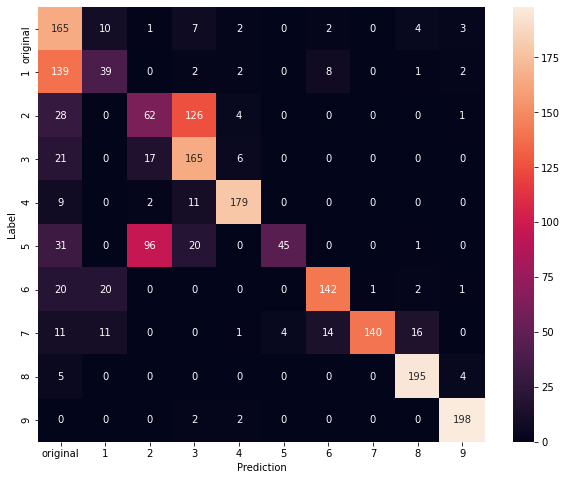

In [20]:
confusion_mtx = tf.math.confusion_matrix(y_test, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()


In [21]:
loss, acc = conv_net.evaluate(x_test, y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))


63/63 - 2s - loss: 1.0109 - accuracy: 0.6650
Restored model, accuracy: 66.50%


In [ ]:
conv_net.summary()

In [ ]:
print(confusion_mtx)

In [ ]:
import pandas as pd
pd.DataFrame(y_pred).to_csv("pred.csv", header=None, index=None)
pd.DataFrame(y_test).to_csv("test.csv", header=None, index=None)
pd.DataFrame(confusion_mtx.numpy()).to_csv("conf.csv",header=None,index=None)

In [ ]:
print(confusion_mtx.numpy())